# LSTM + attention mechanism for classification with keras


In [1]:
import pandas as pd
from csv import reader
import numpy as np
#from google.colab import drive
#drive.mount('/content/gdrive')

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import RepeatVector
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam



import tensorflow.keras
import tensorflow.keras.backend as K

import matplotlib.pyplot as plot

pd.set_option('display.max_columns', 50)
from tensorflow.keras.layers import Layer

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(tf.__version__)
import tensorflow.keras
print(tensorflow.keras.__version__)


2.2.0
2.3.0-tf


In [2]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Benign' 'Bot' 'DoS attacks-SlowHTTPTest' 'DoS attacks-Hulk' 'Label'
 'Brute Force -Web' 'Brute Force -XSS' 'SQL Injection'
 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris' 'FTP-BruteForce'
 'SSH-Bruteforce' 'DDOS attack-LOIC-UDP' 'DDOS attack-HOIC'
 'Infilteration' 'DDoS attacks-LOIC-HTTP']
(4096753, 80)
True
(4096753, 79)


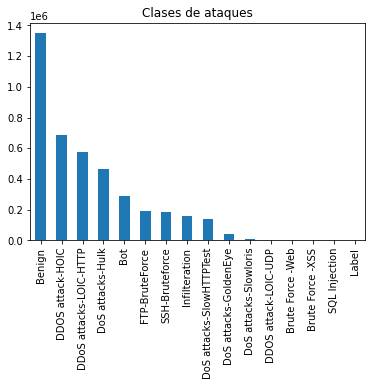

In [3]:
muestraDF=pd.read_csv("DF_undersample.csv",sep=',')
print (pd.unique(muestraDF.iloc[:,-1].squeeze()))
print(muestraDF.shape)
print(muestraDF.isna().values.any())
muestraDF=muestraDF.drop(columns=[' Timestamp'],axis=1)
print(muestraDF.shape)
plot = muestraDF['Label'].value_counts().plot(kind='bar',
                                            title='Clases de ataques')



In [5]:
muestraDF.drop(muestraDF.loc[muestraDF['Label']=='Label'].index, inplace=True)
print(muestraDF.shape)
y=muestraDF.iloc[:,-1]
print (pd.unique(y.squeeze()))
X=muestraDF.iloc[:,0:78]
X = X.replace([np.inf, -np.inf], np.nan)
nom_cols=['Dst Port',' Protocol',' Flow Duration',' Tot Fwd Pkts',' Tot Bwd Pkts',' TotLen Fwd Pkts',' TotLen Bwd Pkts',' Fwd Pkt Len Max',' Fwd Pkt Len Min',' Fwd Pkt Len Mean',' Fwd Pkt Len Std',' Bwd Pkt Len Max',' Bwd Pkt Len Min',' Bwd Pkt Len Mean',' Bwd Pkt Len Std',' Flow Byts/s',' Flow Pkts/s',' Flow IAT Mean',' Flow IAT Std',' Flow IAT Max',' Flow IAT Min',' Fwd IAT Tot',' Fwd IAT Mean',' Fwd IAT Std',' Fwd IAT Max',' Fwd IAT Min',' Bwd IAT Tot',' Bwd IAT Mean',' Bwd IAT Std',' Bwd IAT Max',' Bwd IAT Min',' Fwd PSH Flags',' Bwd PSH Flags',' Fwd URG Flags',' Bwd URG Flags',' Fwd Header Len',' Bwd Header Len',' Fwd Pkts/s',' Bwd Pkts/s',' Pkt Len Min',' Pkt Len Max',' Pkt Len Mean',' Pkt Len Std',' Pkt Len Var',' FIN Flag Cnt',' SYN Flag Cnt',' RST Flag Cnt',' PSH Flag Cnt',' ACK Flag Cnt',' URG Flag Cnt',' CWE Flag Count',' ECE Flag Cnt',' Down/Up Ratio',' Pkt Size Avg',' Fwd Seg Size Avg',' Bwd Seg Size Avg',' Fwd Byts/b Avg',' Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',' Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',' Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',' Active Min', 'Idle Mean', 'Idle Std', 'Idle Max','Idle Min']
for i in nom_cols:
    X[i]=pd.to_numeric(X[i], errors='coerce')
    X[i] = X[i].fillna(X[i].mean())
print(X.isna().values.any())
print(X.dtypes)
X.index[np.isinf(X).any(1)]

(4096694, 79)
['Benign' 'Bot' 'DoS attacks-SlowHTTPTest' 'DoS attacks-Hulk'
 'Brute Force -Web' 'Brute Force -XSS' 'SQL Injection'
 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris' 'FTP-BruteForce'
 'SSH-Bruteforce' 'DDOS attack-LOIC-UDP' 'DDOS attack-HOIC'
 'Infilteration' 'DDoS attacks-LOIC-HTTP']
False
Dst Port            int64
 Protocol           int64
 Flow Duration      int64
 Tot Fwd Pkts       int64
 Tot Bwd Pkts       int64
                   ...   
 Active Min       float64
Idle Mean         float64
Idle Std          float64
Idle Max          float64
Idle Min          float64
Length: 78, dtype: object


Int64Index([     66,     105,     110,     116,   32494,   32513,   43093,
              43128,   43137,   43138,
            ...
            4085176, 4085198, 4085904, 4087502, 4087517, 4087536, 4087881,
            4089289, 4089296, 4089457],
           dtype='int64', length=10561)

In [6]:
X = X.replace([np.inf, -np.inf], np.nan)
for i in nom_cols:
    X[i]=pd.to_numeric(X[i], errors='coerce')
    X[i] = X[i].fillna(X[i].mean())

X.index[np.isinf(X).any(1)]
print(X.isna().values.any())
X.index[np.isinf(X).any(1)]


False


Int64Index([], dtype='int64')

['Benign' 'Bot' 'DoS' 'Web_attack' 'Bruteforce' 'DDoS' 'Infilteration']
Int64Index([], dtype='int64')
False
(4096694, 78)
(4111766, 78)


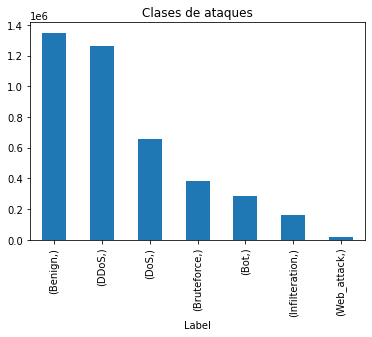

In [7]:
y=y.replace (['DDOS attack-LOIC-UDP', 'DDOS attack-HOIC','DDoS attacks-LOIC-HTTP'],'DDoS')
y=y.replace (['Brute Force -Web', 'Brute Force -XSS', 'SQL Injection'],'Web_attack')
y=y.replace (['FTP-BruteForce', 'SSH-Bruteforce'],'Bruteforce')
y=y.replace (['DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk'],'DoS')

plot = y.value_counts().plot(kind='bar',
                                            title='Clases de ataques')


feats = X.shape[1]
print (pd.unique(y.squeeze()))
print(X.index[np.isinf(X).any(1)])
print(X.isna().values.any())
print (X.shape)

sm = SMOTE(sampling_strategy = {'Web_attack':16000})
X_smote, y_smote = sm.fit_resample(X, y)
print(X_smote.shape)


(5444225, 78)


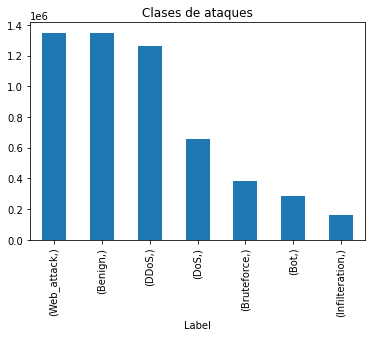

In [12]:
sm = SMOTE(sampling_strategy = 'minority')
X_smote, y_smote = sm.fit_resample(X, y)
print(X_smote.shape)
plot = pd.DataFrame(data=y_smote).value_counts().plot(kind='bar',
                                            title='Clases de ataques')

In [13]:
X_Train, X_2, y_Train, y_2= train_test_split(X, y, test_size=0.1, random_state=1)
X_Test, X_Val, y_Test, y_Val = train_test_split(X_Train, y_Train, test_size=0.1, random_state=1) 

print(X_Train.isna().values.any())
print(X_Test.isna().values.any())
print(X_Val.isna().values.any())


False
False
False


In [ ]:

#X_Val=pd.read_csv("X_Val.csv",sep=',',dtype=np.float32)
#y_Val=pd.read_csv("y_Val.csv",sep=',')
print (pd.unique(y_Val.squeeze()))
print (y_Val.shape)
print (X_Val.shape)
cant_clases = pd.unique(y_Val.squeeze())

print (cant_clases)

In [18]:
cant_clases = pd.unique(y_Val.squeeze())


In [14]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_enco = encoder.fit_transform(y_Train)
y_enc = pd.DataFrame(data=y_enco)
print(y_enc.head(2))

encoder = LabelBinarizer()
y_Val_enco = encoder.fit_transform(y_Val)
y_Val_enc = pd.DataFrame(data=y_Val_enco)
print(y_Val_enc.head(2))

   0  1  2  3  4  5  6
0  0  0  0  1  0  0  0
1  1  0  0  0  0  0  0
   0  1  2  3  4  5  6
0  0  0  0  1  0  0  0
1  0  0  0  1  0  0  0


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Create minmax coef
scaler = scaler.fit(X_Train)
#print(' Min: %f, Max: %f ' % (scaler.data_min_, scaler.data_max_))
# transform data
#X.drop(X.tail(X.shape[0]%10).index,inplace=True)
#X_Val.drop(X_Val.tail(X_Val.shape[0]%10).index,inplace=True)
#print(X.shape)
#print(X_Val.shape)


scaled_X = scaler.transform(X_Train)
scaled_X_Val = scaler.transform(X_Val)

In [16]:
def arch():
    model = Sequential()
    model.add(LSTM(256,input_shape=(1,78),activation='relu',return_sequences=True))
    model.add(LSTM(256,activation='relu',return_sequences=True))
    model.add(attention())
    model.add(Dense(cant_clases.size))
    model.add(Dense(20))
    model.add(Dense(cant_clases.size*2))
    model.add(Dense(cant_clases.size, activation='softmax'))
    opt = Adam(learning_rate=0.00005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'],)
    return model

In [19]:
model = arch()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 256)            343040    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
attention_1 (attention)      (None, 256)               257       
_________________________________________________________________
dense (Dense)                (None, 7)                 1799      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 14)                294       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                

In [20]:
X=scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1]))
print(X.shape)
X_t=scaled_X_Val.reshape((scaled_X_Val.shape[0], 1, scaled_X_Val.shape[1]))
print(X_t.shape)


(3687024, 1, 78)
(368703, 1, 78)


In [ ]:
his=model.fit(X, y_enc, validation_data=(X_t, y_Val_enc), epochs=70, verbose=2,batch_size=128)
 #especificar batch con batch_input_shape (batch,features,?)

Epoch 1/70
28805/28805 - 326s - loss: 0.2643 - accuracy: 0.9052 - val_loss: 0.1674 - val_accuracy: 0.9364
Epoch 2/70
28805/28805 - 328s - loss: 0.1622 - accuracy: 0.9370 - val_loss: 0.1590 - val_accuracy: 0.9387
Epoch 3/70
28805/28805 - 327s - loss: 0.1562 - accuracy: 0.9395 - val_loss: 0.1541 - val_accuracy: 0.9405
Epoch 4/70
28805/28805 - 327s - loss: 0.1533 - accuracy: 0.9403 - val_loss: 0.1541 - val_accuracy: 0.9403
Epoch 5/70
28805/28805 - 328s - loss: 0.1516 - accuracy: 0.9407 - val_loss: 0.1532 - val_accuracy: 0.9408
Epoch 6/70
28805/28805 - 327s - loss: 0.1503 - accuracy: 0.9411 - val_loss: 0.1504 - val_accuracy: 0.9407
Epoch 7/70
28805/28805 - 326s - loss: 0.1493 - accuracy: 0.9414 - val_loss: 0.1495 - val_accuracy: 0.9413
Epoch 8/70
28805/28805 - 327s - loss: 0.1485 - accuracy: 0.9417 - val_loss: 0.1497 - val_accuracy: 0.9413
Epoch 9/70
28805/28805 - 327s - loss: 0.1478 - accuracy: 0.9419 - val_loss: 0.1478 - val_accuracy: 0.9416
Epoch 10/70
28805/28805 - 327s - loss: 0.1472 

In [ ]:
model.save('2LSTM_ATT_3Dense_21jul2021.h5')

In [ ]:
import matplotlib.pyplot as plt


plt.plot(his.history['loss' ])
plt.plot(his.history[ 'val_loss' ])
plt.title( 'model train vs validation loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'validation' ], loc= 'upper_right' )
plt.show()

plt.plot(his.history['accuracy' ])
plt.plot(his.history[ 'val_accuracy' ])
plt.title( 'model train vs validation accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'validation' ], loc= 'upper_right' )
plt.show()

In [ ]:
#https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# predict probabilities for test set
yhat_probs = model.predict(X_t, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_t, verbose=0)

yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_Val, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_Val, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_Val, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_Val, yhat_classes)
print('F1 score: %f' % f1)